This notebook is under progress.

The purpose of this notebook is to implement the UNet architecture for chest CT segmentation.

UNet Paper: https://arxiv.org/pdf/1505.04597
Original Dataset: https://www.kaggle.com/datasets/polomarco/chest-ct-segmentation

In [8]:
import os, sys
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

In [9]:
data_dir = "../data/unet/"
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

ImageId                                MaskId
0  ID00007637202177411956430_0.jpg  ID00007637202177411956430_mask_0.jpg
1  ID00007637202177411956430_1.jpg  ID00007637202177411956430_mask_1.jpg
2  ID00007637202177411956430_2.jpg  ID00007637202177411956430_mask_2.jpg
3  ID00007637202177411956430_3.jpg  ID00007637202177411956430_mask_3.jpg
4  ID00007637202177411956430_4.jpg  ID00007637202177411956430_mask_4.jpg

In [10]:
def get_client_id(x):
  return x.split("_")[0]

In [11]:
data_df["Id"] = data_df.ImageId.apply(lambda x:get_client_id(x))
data_df

ImageId  \
0        ID00007637202177411956430_0.jpg   
1        ID00007637202177411956430_1.jpg   
2        ID00007637202177411956430_2.jpg   
3        ID00007637202177411956430_3.jpg   
4        ID00007637202177411956430_4.jpg   
...                                  ...   
16703  ID00426637202313170790466_403.jpg   
16704  ID00426637202313170790466_404.jpg   
16705  ID00426637202313170790466_405.jpg   
16706  ID00426637202313170790466_406.jpg   
16707  ID00426637202313170790466_407.jpg   

                                       MaskId                         Id  
0        ID00007637202177411956430_mask_0.jpg  ID00007637202177411956430  
1        ID00007637202177411956430_mask_1.jpg  ID00007637202177411956430  
2        ID00007637202177411956430_mask_2.jpg  ID00007637202177411956430  
3        ID00007637202177411956430_mask_3.jpg  ID00007637202177411956430  
4        ID00007637202177411956430_mask_4.jpg  ID00007637202177411956430  
...                                       ...                        ...  
16703  ID00426637202313170790466_mask_403.jpg  ID00426637202313170790466  
16704  ID00426637202313170790466_mask_404.jpg  ID00426637202313170790466  
16705  ID00426637202313170790466_mask_405.jpg  ID00426637202313170790466  
16706  ID00426637202313170790466_mask_406.jpg  ID00426637202313170790466  
16707  ID00426637202313170790466_mask_407.jpg  ID00426637202313170790466  

[16708 rows x 3 columns]

In [12]:
client_ids = np.unique(data_df["Id"])
print(client_ids[:5])
print("Number of clients:", len(client_ids))

['ID00007637202177411956430' 'ID00009637202177434476278'
 'ID00010637202177584971671' 'ID00012637202177665765362'
 'ID00014637202177757139317']
Number of clients: 112


In [13]:
client_index = 0
client_data = data_df[data_df["Id"] == client_ids[client_index]][["ImageId","MaskId"]]
client_data[:5]

ImageId                                MaskId
0  ID00007637202177411956430_0.jpg  ID00007637202177411956430_mask_0.jpg
1  ID00007637202177411956430_1.jpg  ID00007637202177411956430_mask_1.jpg
2  ID00007637202177411956430_2.jpg  ID00007637202177411956430_mask_2.jpg
3  ID00007637202177411956430_3.jpg  ID00007637202177411956430_mask_3.jpg
4  ID00007637202177411956430_4.jpg  ID00007637202177411956430_mask_4.jpg

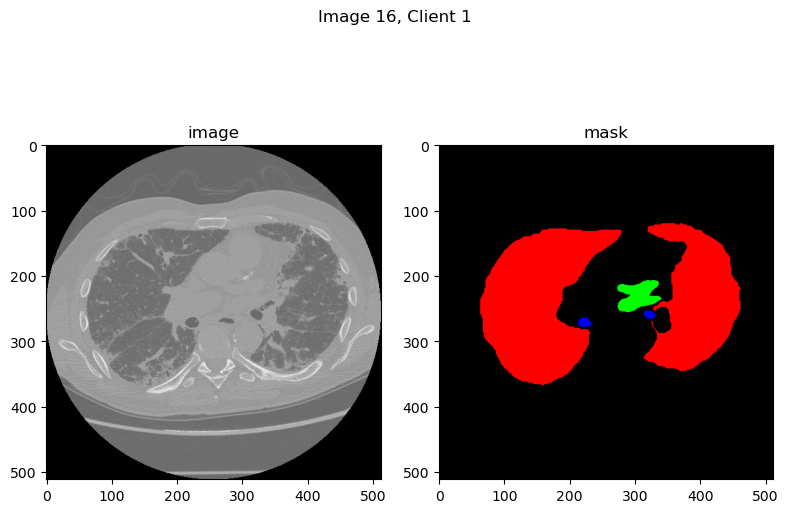

In [14]:
image_index = 15
img_name, mask_name = client_data.iloc[image_index].values
img_path, mask_path = os.path.join(data_dir, "images", img_name), os.path.join(data_dir, "masks", mask_name)
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)
thres = 240
mask[mask < thres] = 0
mask[mask >= thres] = 255

plt.figure(figsize=(8,6))
plt.suptitle(f"Image {image_index + 1}, Client {client_index + 1}")
plt.subplot(121)
plt.title("image")
plt.imshow(image)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [15]:
def get_client_data(data_df, client_index):
    client_ids = np.unique(data_df.Id.values)
    client_id = client_ids[client_index]
    client_data = data_df[data_df["Id"] == client_id][["ImageId","MaskId"]]
    image_files = list(client_data["ImageId"])
    mask_files = list(client_data["MaskId"])
    return client_id, image_files, mask_files

In [16]:
# Background: Black
# Trachea: Blue
# Heart: Green
# Lung: Red
classes = ["background", "trachea", "heart", "lung"]
colors = ((0,0,0), (255, 0, 0), (0, 255, 0), (0, 0, 255)) # in BGR forman

In [10]:
# Loop through CT image for client 1 and save as a video using CV2
def create_video_from_images(data_df, index, data_dir, output_video_path, fps=10):
    client_id, image_files, mask_files = get_client_data(data_df, index)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    canvas_height, canvas_width = 512, 2 * 512 + 50
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (canvas_width, canvas_height))

    for i in range(len(image_files)):
        image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        thres = 240
        mask[mask < thres] = 0
        mask[mask >= thres] = 255
        canvas = np.zeros(shape=(canvas_height, canvas_width, 3), dtype=np.uint8)
        grid_pad = 50
        
        canvas[:, :512, :] = image
        canvas[:, 512 + grid_pad:2 * 512 + grid_pad, :] = mask

        text_buff = 410
        for j in range(1, len(classes)):
            cv2.putText(canvas, f'{classes[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
            text_buff += 40
            
        out.write(canvas)
        cv2.imshow('CT frames', canvas)
        key = cv2.waitKey(100)

    out.release()
    cv2.destroyAllWindows()

index = 0
output_video_path = os.path.join(data_dir, 'sample_CT.mp4')
fps = 10  # Frames per second
create_video_from_images(data_df, index, data_dir, output_video_path, fps)

In [11]:
# Split all images/masks into 9:1 ratio for train and validation. 'split_train_val' creates train and val folders and copies over from data_dir
import shutil

def split_train_val(data_dir):
    train_folder = os.path.join(data_dir, 'train')
    val_folder = os.path.join(data_dir, 'val')
    
    if not (os.path.exists(train_folder) and os.path.exists(val_folder)):
        for folder in ['train', 'val']:
            os.makedirs(os.path.join(data_dir, folder, 'images'), exist_ok=True)
            os.makedirs(os.path.join(data_dir, folder, 'masks'), exist_ok=True)
        
        image_files = [f for f in os.listdir(os.path.join(data_dir, 'images')) if os.path.isfile(os.path.join(data_dir, 'images', f))]
        mask_files = [f for f in os.listdir(os.path.join(data_dir, 'masks')) if os.path.isfile(os.path.join(data_dir, 'masks', f))]
        image_mask_pairs = [(img, mask) for img, mask in zip(image_files, mask_files)]
        
        num_train = 0
        for i in range(round(len(client_ids) * 0.9)):
            num_train += len(data_df[data_df["Id"] == client_ids[i]])
        num_val = len(data_df) - num_train
        print(f"# of Training Images: {num_train} ({round(len(client_ids) * 0.9)} clients)")
        print(f"# of Validation Images: {num_val} ({len(client_ids) - round(len(client_ids) * 0.9)} clients)")
        train_pairs = image_mask_pairs[:num_train]
        val_pairs = image_mask_pairs[num_train:]
        
        for img, mask in train_pairs:
            shutil.copy(os.path.join(data_dir, 'images', img), os.path.join(data_dir, 'train', 'images', img))
            shutil.copy(os.path.join(data_dir, 'masks', mask), os.path.join(data_dir, 'train', 'masks', mask))
        
        for img, mask in val_pairs:
            shutil.copy(os.path.join(data_dir, 'images', img), os.path.join(data_dir, 'val', 'images', img))
            shutil.copy(os.path.join(data_dir, 'masks', mask), os.path.join(data_dir, 'val', 'masks', mask))

split_train_val(data_dir)

In [17]:
class CT_dataset():
    def __init__(self, data_dir, stage, transforms=None):
        self.images_dir = os.path.join(data_dir, stage, "images")
        self.masks_dir = os.path.join(data_dir, stage, "masks")
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("jpg")]
        self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("jpg")]
        self.stage = stage
        self.transforms = transforms
        self.IMAGE_SIZE = 224 #per UNet architecture

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Resize could be under torch transforms, but we need different interpolations for image and mask.
        # For easier use of dataloader, resize and interpolation is done as we build CT dataset
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]).replace("\\","/"))
        image = cv2.resize(image, dsize=(self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]).replace("\\","/"))
        mask = cv2.resize(mask, dsize=(self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255

        mask_H, mask_W, mask_C = mask.shape
        background = np.ones(shape=(mask_H, mask_W))
        background[mask[...,0] != 0] = 0
        background[mask[...,1] != 0] = 0
        background[mask[...,2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, -1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1, keepdims=False)

        if self.transforms:
            image = self.transforms(image)
        target = torch.from_numpy(mask).long()
        return image, target

In [18]:
from PIL import Image
from torchvision import transforms

def get_transformation():
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transformation

# image_transforms = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.BILINEAR),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #ImageNet mean, std
# ])

# mask_transforms = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
#     transforms.ToTensor()
# ])

In [19]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch:
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)

    return images, targets

In [20]:
from torch.utils.data import DataLoader

def get_dataloader(data_dir, batch_size=4):
    transforms = get_transformation()

    dataloaders = {}
    train_dataset = CT_dataset(data_dir=data_dir, stage="train", transforms=transforms)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    val_dataset = CT_dataset(data_dir=data_dir, stage="val", transforms=transforms)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [21]:
for index, batch in enumerate(get_dataloader(data_dir)["train"]):
    images = batch[0]
    targets = batch[1]
    print(f"images shape: {images.shape}")
    print(f"masks shape: {targets.shape}")
    break

images shape: torch.Size([4, 3, 224, 224])
masks shape: torch.Size([4, 224, 224])


In [22]:
import torch.nn as nn

In [23]:
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layers

Now we define the Encoder (i.e. contracting path). We undergo 5 ConvBlocks to downsample and increase the channels. We also save the outputs of each ConvBlocks so that we can concatenate to the corresponding feature map in the Decoder.

In [24]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        encoder_features = []
        out = self.conv_block1(x)
        encoder_features.append(out)
        out = self.maxpool(out)

        out = self.conv_block2(out)
        encoder_features.append(out)
        out = self.maxpool(out)

        out = self.conv_block3(out)
        encoder_features.append(out)
        out = self.maxpool(out)

        out = self.conv_block4(out)
        encoder_features.append(out)
        out = self.maxpool(out)

        out = self.conv_block5(out)
        return out, encoder_features

In [25]:
encoder = Encoder()
x = torch.randn(1, 3, 224, 224)
out, encoder_features = encoder(x)

In [26]:
for feature in encoder_features:
    print(feature.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


In [27]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

Now we define the Decoder (i.e. expansive path). It uses UpConv layer to expand the dimensions (W, H) of the feature map, followed by ConvBlock. In the forward function we concatenate the encoder output for skip connection. We crop the encoder output to match the dimensions with the decoder output.

In [28]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)

        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)

        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)

        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)

    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block1(out)

        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)

        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)

        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out

    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [29]:
encoder = Encoder()
decoder = Decoder()
x = torch.randn(1, 3, 224, 224)
out, encoder_features = encoder(x)
out = decoder(out, encoder_features)

In [30]:
print(out.shape)

torch.Size([1, 64, 224, 224])


In [31]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.output_map = nn.Conv2d(64, num_classes, kernel_size=1)
        self.retain_input_dim = retain_input_dim

    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.output_map(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [32]:
model = UNet(num_classes=4)
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 4, 224, 224])


If we had two classes, binary cross entropy loss would be a good loss function to use. Here, we have four classes, so we could use categorical cross entropy loss. We will also explore dice loss, as the background takes up majority of the pixels (i.e. class imbalance). In case of binary segmentation task, dice coefficient is equal to F1 score.
$$
\text{Dice Coefficient} = \frac{2 \cdot \text{TP}}{2 \cdot \text{TP} + \text{FP} + \text{FN}}
$$
$$
\text{Dice Loss} = 1 - \text{Dice Coefficient}
$$


In [33]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on", DEVICE)
model = UNet(4).to(DEVICE)
LR = 0.001
MOMENTUM = 0.9
EPOCHS = 10
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

Running on cuda


In [35]:
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    model.train()
    print("Epoch %d:" %i)
    for batch_idx, (inputs, targets) in enumerate(get_dataloader(data_dir)["train"]):
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        out = model(inputs)
        loss = criterion(out, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Training loss: %.4f" %(loss))
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(get_dataloader(data_dir)["val"]):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            out = model(inputs)
            loss = criterion(out, targets)
    print("Validation loss: %.4f" %(loss))

==> Training starts!
Epoch 0:
Training loss: 0.3415
Validation loss: 0.0371
Epoch 1:
Training loss: 0.3339
Validation loss: 0.0833
Epoch 2:
Training loss: 0.3255
Validation loss: 0.0995
Epoch 3:
Training loss: 0.3257
Validation loss: 0.0763
Epoch 4:


KeyboardInterrupt: 